[View in Colaboratory](https://colab.research.google.com/github/hhngan/MLFollow/blob/master/ML_Retail_Price_Recommendation.ipynb)

*Mercari, Japan’s biggest community-powered shopping app, knows one problem deeply. They’d like to offer pricing suggestions to sellers, but this is tough because their sellers are enabled to put just about anything, or any bundle of things, on Mercari’s marketplace.*

In this machine learning project, we will build a model that automatically suggests the right product prices. We are provided of the following information:

* train_id — the id of the listing

* name — the title of the listing

* item_condition_id — the condition of the items provided by the sellers

* category_name — category of the listing

* brand_name — the name of the brand

* price — the price that the item was sold for. This is target variable that we will predict

* shipping — 1 if shipping fee is paid by seller and 0 by buyer

* item_description — the full description of the item

In [0]:
#!pip install -q lightgbm --> using in Google Colaboratory only.

# Import library

In [0]:
import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

#Import data from file
FILE_PATHS = "https://raw.githubusercontent.com/pjankiewicz/mercari-solution/master/tests/train_10k.tsv"

df = pd.read_csv(FILE_PATHS, sep = '\t')

> Randomly split the data into train and test sets. We are using training set only for EDA.

In [7]:
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]
train.shape, test.shape

((7925, 8), (2075, 8))

In [8]:
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
train_id             10000 non-null int64
name                 10000 non-null object
item_condition_id    10000 non-null int64
category_name        9953 non-null object
brand_name           5739 non-null object
price                10000 non-null float64
shipping             10000 non-null int64
item_description     10000 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 625.1+ KB


**Price**

In [10]:
train.price.describe()

count    7925.000000
mean       26.344038
std        36.158886
min         0.000000
25%        10.000000
50%        16.000000
75%        29.000000
max       749.000000
Name: price, dtype: float64

>The price of items are left skewed, vast majority of the items priced at 10–20. However, the most expensive item priced at 2009. So we will make log-transformation on the price.

Text(0.5,1,'Price Distribution')

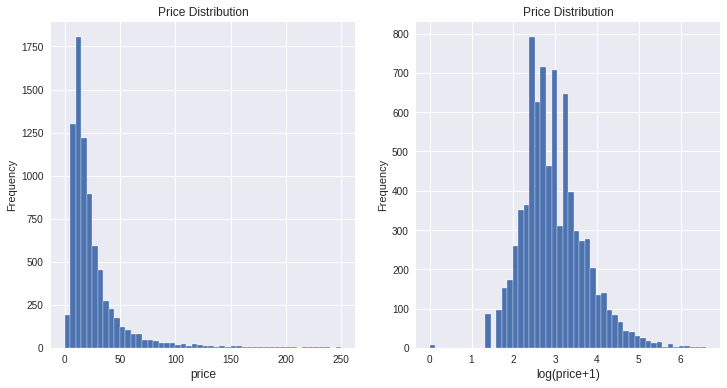

In [11]:
plt.subplot(1, 2, 1)
(train['price']).plot.hist(bins=50, figsize=(12, 6), edgecolor = 'white', range = [0, 250])
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)
plt.subplot(1, 2, 2)
np.log(train['price']+1).plot.hist(bins=50, figsize=(12,6), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Price Distribution', fontsize=12)

**Shipping**

Over 55% of items shipping fee were paid by the buyers.

In [12]:
train['shipping'].value_counts() / len(train)

0    0.547508
1    0.452492
Name: shipping, dtype: float64

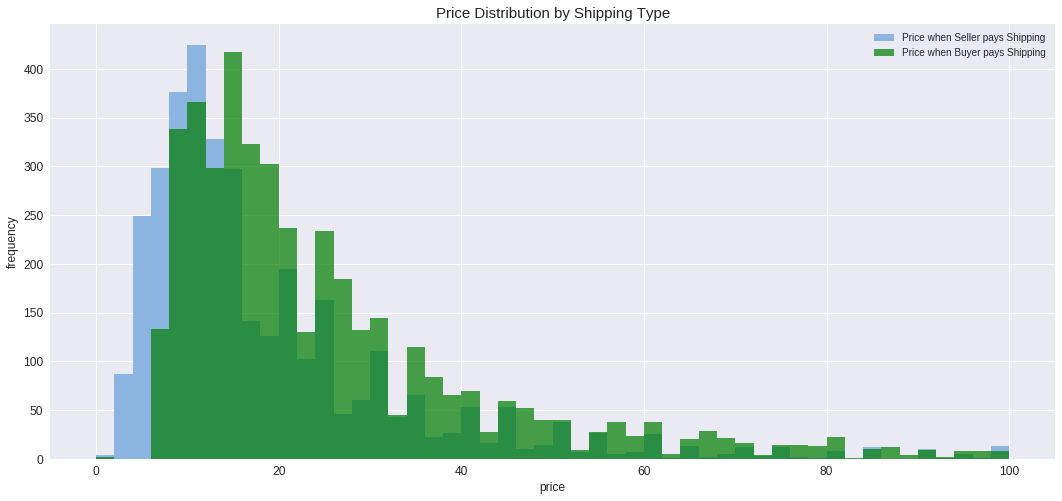

In [13]:
#How shipping related to the price?

shipping_fee_by_buyer = train.loc[df['shipping'] == 0, 'price']
shipping_fee_by_seller = train.loc[df['shipping'] == 1, 'price']
fig, ax = plt.subplots(figsize=(18,8))
ax.hist(shipping_fee_by_seller, color='#8CB4E1', alpha=1.0, bins=50, range = [0, 100],
       label='Price when Seller pays Shipping')
ax.hist(shipping_fee_by_buyer, color='#007D00', alpha=0.7, bins=50, range = [0, 100],
       label='Price when Buyer pays Shipping')
plt.xlabel('price', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

In [14]:
#Show avg by each term

print('The average price is {}'.format(round(shipping_fee_by_seller.mean(), 2)), 'if seller pays shipping');
print('The average price is {}'.format(round(shipping_fee_by_buyer.mean(), 2)), 'if buyer pays shipping')

The average price is 22.35 if seller pays shipping
The average price is 29.64 if buyer pays shipping


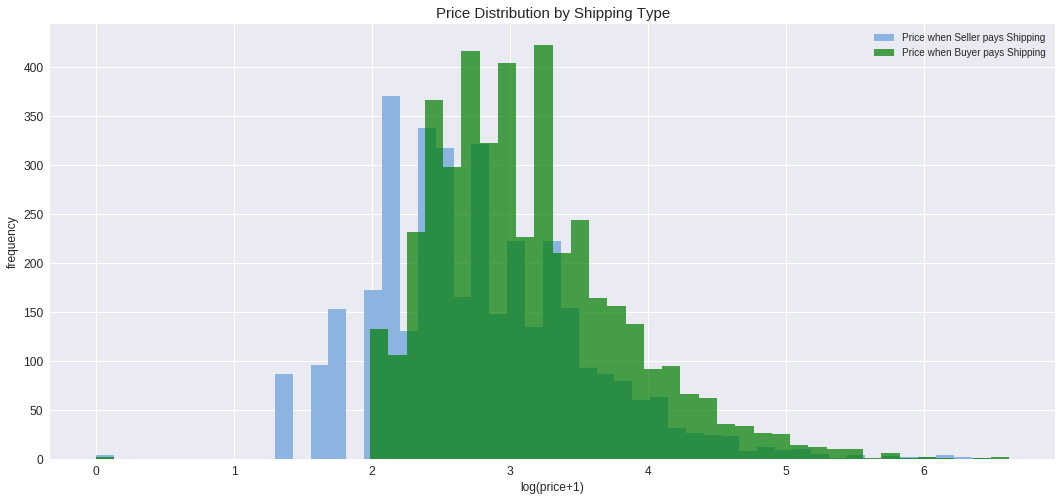

In [15]:
#We compare again after log-transformation on the price.

fig, ax = plt.subplots(figsize=(18,8))
ax.hist(np.log(shipping_fee_by_seller+1), color='#8CB4E1', alpha=1.0, bins=50,
       label='Price when Seller pays Shipping')
ax.hist(np.log(shipping_fee_by_buyer+1), color='#007D00', alpha=0.7, bins=50,
       label='Price when Buyer pays Shipping')
plt.xlabel('log(price+1)', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

#Obviously:--> It is obvious that the average price is higher when buyer pays shipping.

**Category Names**

In [16]:
print('There are', train['category_name'].nunique(), 'unique values in category name column')

There are 586 unique values in category name column


In [17]:
# Top 10 most common category names:
train['category_name'].value_counts()[:10]

Women/Athletic Apparel/Pants, Tights, Leggings                 315
Women/Tops & Blouses/T-Shirts                                  237
Beauty/Makeup/Face                                             209
Beauty/Makeup/Lips                                             179
Beauty/Makeup/Eyes                                             148
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    135
Electronics/Video Games & Consoles/Games                       124
Women/Tops & Blouses/Blouse                                    116
Beauty/Fragrance/Women                                         115
Women/Tops & Blouses/Tank, Cami                                112
Name: category_name, dtype: int64

**Item condition vs. Price**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


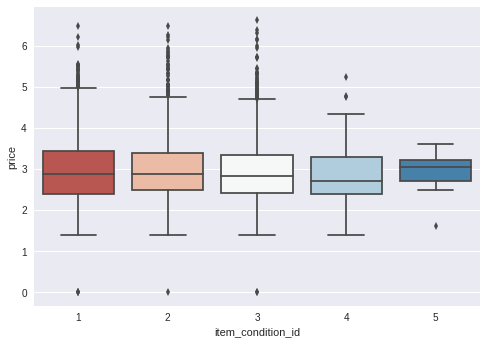

In [18]:
#using seaborn lib
sns.boxplot(x = 'item_condition_id', y = np.log(train['price']+1), data = train, palette = sns.color_palette('RdBu',5))

## Obviously:--> There seems to be various on the average price between each item condition id.

# Build Model


After above exploratory data analysis, I decide to use all the features to build our model.


**LightGBM**

Under the umbrella of the [DMTK](https://www.microsoft.com/en-us/research/project/dmtk/) project of Microsoft, [LightGBM](https://github.com/Microsoft/LightGBM) is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

* Faster training speed and higher efficiency
* Lower memory usage
* Better accuracy
* Parallel and GPU learning supported
* Capable of handling large-scale data


>Therefore, we are going to give it a try.

In [0]:
# General settings

NUM_BRANDS = 4000
NUM_CATEGORIES = 1000
NAME_MIN_DF = 10
MAX_FEATURES_ITEM_DESCRIPTION = 50000

In [20]:
# There are missing values in the columns that we have to fix:

print('There are %d items that do not have a category name.' %train['category_name'].isnull().sum())

There are 35 items that do not have a category name.


In [21]:
print('There are %d items that do not have a description.' %train['item_description'].isnull().sum())

There are 0 items that do not have a description.


**Helper function for LightGBM**

In [0]:
def handle_missing_inplace(dataset): 
    dataset['category_name'].fillna(value='missing', inplace=True) 
    dataset['brand_name'].fillna(value='missing', inplace=True) 
    dataset['item_description'].replace('No description yet,''missing', inplace=True) 
    dataset['item_description'].fillna(value='missing', inplace=True)
def cutting(dataset):
    pop_brand = dataset['brand_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_BRANDS]
    dataset.loc[~dataset['brand_name'].isin(pop_brand), 'brand_name'] = 'missing'
    pop_category = dataset['category_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_CATEGORIES]
def to_categorical(dataset):
    dataset['category_name'] = dataset['category_name'].astype('category')
    dataset['brand_name'] = dataset['brand_name'].astype('category')
    dataset['item_condition_id'] = dataset['item_condition_id'].astype('category')

In [0]:
# Drop rows where price = 0

df = pd.read_csv(FILE_PATHS, sep = '\t')
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]
test_new = test.drop('price', axis=1)
y_test = np.log1p(test["price"])
train = train[train.price != 0].reset_index(drop=True)

In [0]:
# Merge train and new test data.

nrow_train = train.shape[0]
y = np.log1p(train["price"])
merge: pd.DataFrame = pd.concat([train, test_new])

# Training Preparation

In [0]:
handle_missing_inplace(merge)
cutting(merge)
to_categorical(merge)

In [0]:
# Count vectorize name and category name columns.

cv = CountVectorizer(min_df=NAME_MIN_DF)
X_name = cv.fit_transform(merge['name'])
cv = CountVectorizer()
X_category = cv.fit_transform(merge['category_name'])

In [0]:
# TF-IDF Vectorize item_description column.

tv = TfidfVectorizer(max_features=MAX_FEATURES_ITEM_DESCRIPTION, ngram_range=(1, 3), stop_words='english')
X_description = tv.fit_transform(merge['item_description'])

In [0]:
# Label binarize brand_name column.

lb = LabelBinarizer(sparse_output=True)
X_brand = lb.fit_transform(merge['brand_name'])

In [0]:
# Create dummy variables for item_condition_id and shipping columns.

X_dummies = csr_matrix(pd.get_dummies(merge[['item_condition_id', 'shipping']], sparse=True).values)

In [0]:
# Create sparse merge.

sparse_merge = hstack((X_dummies, X_description, X_brand, X_category, X_name)).tocsr()

In [0]:
# Remove features with document frequency <=1.

mask = np.array(np.clip(sparse_merge.getnnz(axis=0) - 1, 0, 1), dtype=bool)
sparse_merge = sparse_merge[:, mask]

In [0]:
# Separate train and test data from sparse merge.

X = sparse_merge[:nrow_train]
X_test = sparse_merge[nrow_train:]

In [0]:
# Create dataset for lightgbm.

train_X = lgb.Dataset(X, label=y)

In [0]:
# Specify our parameters as a dict.

params = {
        'learning_rate': 0.75,
        'application': 'regression',
        'max_depth': 3,
        'num_leaves': 100,
        'verbosity': -1,
        'metric': 'RMSE',
    }

# Training Start

* Use ‘regression’ as application as we are dealing with a regression problem.
* Use ‘RMSE’ as metric because this is a regression problem.
* “num_leaves”=100 as our data is relative big.
* Use “max_depth” to avoid overfitting.
* Use “verbosity” to control the level of LightGBM’s verbosity (<0: Fatal).
* “learning_rate” determines the impact of each tree on the final outcome.

Training a model requires a parameter list and data set. And training will take a while.

In [0]:
gbm = lgb.train(params, train_set=train_X, num_boost_round=3200, verbose_eval=100)

**Predict**

In [0]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

**Evaluation**

In [37]:
from sklearn.metrics import mean_squared_error
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

The rmse of prediction is: 0.7064395202141318
